imports + config globale 

In [1]:
import os, glob, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120



In [45]:
# ============================
# Reproducibility & environment
# ============================
import sys, platform, multiprocessing
import sklearn

print("=== Reproducibility ===")
print("Python version   :", sys.version.split()[0])
print("Platform         :", platform.platform())
print("CPU cores        :", multiprocessing.cpu_count())
print("NumPy version    :", np.__version__)
print("scikit-learn ver :", sklearn.__version__)
print("XGBoost version  :", xgb.__version__)
print("Random seed      :", RANDOM_STATE)


=== Reproducibility ===
Python version   : 3.10.18
Platform         : macOS-11.3.1-arm64-arm-64bit
CPU cores        : 8
NumPy version    : 1.26.4
scikit-learn ver : 1.6.1
XGBoost version  : 3.1.2
Random seed      : 42


In [44]:
import multiprocessing
print("CPU cores:", multiprocessing.cpu_count())


CPU cores: 8


parametre "experience" 

In [2]:
# Chemin segments préprocessés
SEGMENTS_DIR = "preprocessed_data/segments"

# Signaux "featureless" : on exclut X,Y pour éviter le leakage spatial
RAW_SIGNAL_COLS_CANDIDATES = ["Speed", "turning_angle"]  # on filtrera selon colonnes présentes

# Définition near-death : derniers N segments
NEAR_DEATH_N_SEGMENTS = 20

# Longueur temporelle cible (frames) : 900 = segment standard
TARGET_LEN = 900

# Mode dev (plus rapide)
USE_SMALL_SUBSET = False
SMALL_SUBSET_SIZE = 3000

# Optionnel : limiter le nombre de fichiers scannés (debug)
MAX_FILES = None  # ex: 500 pour debug, sinon None


verification rapide des fichiers et colonnes 

In [3]:
files = glob.glob(os.path.join(SEGMENTS_DIR, "*.csv"))
if MAX_FILES is not None:
    files = files[:MAX_FILES]

print(f"Found {len(files)} segment files in {SEGMENTS_DIR}")
if len(files) == 0:
    raise RuntimeError("No segment CSV found. Check SEGMENTS_DIR path.")

df_ex = pd.read_csv(files[0])
print("Example file:", os.path.basename(files[0]))
print("Columns:", df_ex.columns.tolist())

# Colonnes réellement disponibles
raw_cols = [c for c in RAW_SIGNAL_COLS_CANDIDATES if c in df_ex.columns]
if len(raw_cols) == 0:
    raise RuntimeError(f"None of {RAW_SIGNAL_COLS_CANDIDATES} found in segment CSV columns.")
print("Using raw signal columns:", raw_cols)


Found 8150 segment files in preprocessed_data/segments
Example file: coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv
Columns: ['GlobalFrame', 'Timestamp', 'Speed', 'X', 'Y', 'condition', 'source_file', 'Segment_index', 'turning_angle', 'worm_id', 'Segment']
Using raw signal columns: ['Speed', 'turning_angle']


loader robuste (padding+troncature) +metadonnées 

corrige définitivement mon bug ValueError: setting an array element with a sequence (longueurs variables)

standardise en (N, 900, C)

In [4]:
def load_segments_featureless(files, raw_cols, target_len=900):
    X_list, worm_ids, seg_idx = [], [], []
    lengths = []
    skipped = 0

    for fp in files:
        try:
            df = pd.read_csv(fp)
        except Exception:
            skipped += 1
            continue

        # Robustesse: worm_id + Segment_index (ou Segment) doivent exister
        if "worm_id" not in df.columns:
            skipped += 1
            continue
        if "Segment_index" in df.columns:
            sidx = df["Segment_index"].iloc[0]
        elif "Segment" in df.columns:
            sidx = df["Segment"].iloc[0]
        else:
            skipped += 1
            continue

        # Récup signaux bruts
        Xraw = df[raw_cols].to_numpy(dtype=float)

        # Nettoyage: NaN/inf -> 0 (simple, featureless)
        Xraw = np.nan_to_num(Xraw, nan=0.0, posinf=0.0, neginf=0.0)

        L = Xraw.shape[0]
        lengths.append(L)

        # Pad / truncate
        C = Xraw.shape[1]
        arr = np.zeros((target_len, C), dtype=float)
        if L >= target_len:
            arr[:] = Xraw[:target_len, :]
        else:
            arr[:L, :] = Xraw

        X_list.append(arr)
        worm_ids.append(df["worm_id"].iloc[0])
        seg_idx.append(int(float(sidx)))  # parfois float dans csv

    X = np.stack(X_list, axis=0)  # (N,T,C) -> évite ton erreur "inhomogeneous shape"
    worm_ids = np.array(worm_ids)
    seg_idx = np.array(seg_idx, dtype=int)

    info = {
        "N": len(X_list),
        "skipped": skipped,
        "min_len": int(np.min(lengths)) if lengths else None,
        "max_len": int(np.max(lengths)) if lengths else None,
        "n_worms": int(len(np.unique(worm_ids)))
    }
    return X, worm_ids, seg_idx, info

X_raw, worm_ids, segment_indices, info = load_segments_featureless(
    files, raw_cols, target_len=TARGET_LEN
)

print("Load info:", info)
print("X_raw shape:", X_raw.shape, "(N,T,C)")
print("Unique worms:", len(np.unique(worm_ids)))


Load info: {'N': 8150, 'skipped': 0, 'min_len': 2, 'max_len': 901, 'n_worms': 104}
X_raw shape: (8150, 900, 2) (N,T,C)
Unique worms: 104


Construction des labels near-death (sans lifespan externe)
-> cohérent avec définition min_features/featureless “derniers N segments”, et n’utilise pas lifespan.csv.

In [5]:
# Pour chaque worm: combien de segments "depuis la fin"
segments_from_end = np.zeros_like(segment_indices, dtype=int)

for wid in np.unique(worm_ids):
    mask = (worm_ids == wid)
    idxs = segment_indices[mask]
    max_seg = idxs.max()
    segments_from_end[mask] = max_seg - idxs

y = (segments_from_end <= NEAR_DEATH_N_SEGMENTS).astype(int)

print("Label distribution (0=far, 1=near):", np.bincount(y))
print("Example segments_from_end:", segments_from_end[:10])


Label distribution (0=far, 1=near): [6016 2134]
Example segments_from_end: [55 34 60 17 75 64 52 14 27  4]


Flatten featureless (pour modeles sklearn) + sous echantillonnae optionnel 

In [6]:
N, T, C = X_raw.shape
X_flat = X_raw.reshape(N, T * C)

groups = worm_ids  # Grouped split par worm

if USE_SMALL_SUBSET:
    n = min(SMALL_SUBSET_SIZE, N)
    idx_sub = np.random.choice(N, size=n, replace=False)
    X_used = X_flat[idx_sub]
    y_used = y[idx_sub]
    groups_used = groups[idx_sub]
    print("Using subset:", X_used.shape, np.bincount(y_used))
else:
    X_used, y_used, groups_used = X_flat, y, groups
    print("Using full data:", X_used.shape, np.bincount(y_used))


Using full data: (8150, 1800) [6016 2134]


In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import numpy as np

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, aucs = [], [], []
for tr, te in cv.split(X_used, y_used, groups=groups_used):
    dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    dummy.fit(X_used[tr], y_used[tr])
    proba = dummy.predict_proba(X_used[te])[:, 1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(y_used[te], pred))
    f1s.append(f1_score(y_used[te], pred))
    aucs.append(roc_auc_score(y_used[te], proba))

print("=== Dummy (stratified) grouped CV ===")
print(f"ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


=== Dummy (stratified) grouped CV ===
ACC: 0.618 ± 0.008
F1 : 0.274 ± 0.016
AUC: 0.508 ± 0.008


definition des modeles a comparer

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

# Optionnel: PCA pour SVM RBF (et parfois Logistic)
from sklearn.decomposition import PCA

models = {}

# Baselines rapides
models["LogReg_l2"] = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

models["HistGB"] = HistGradientBoostingClassifier(
    learning_rate=0.1, max_depth=3, max_iter=300,
    class_weight="balanced", random_state=RANDOM_STATE
)

# Tree ensembles
models["RandomForest"] = RandomForestClassifier(
    n_estimators=600, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

models["ExtraTrees"] = ExtraTreesClassifier(
    n_estimators=800, min_samples_leaf=2,
    class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
)

# SVM RBF : avec PCA pour être faisable
models["SVM_RBF_PCA100"] = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100, random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced",
               probability=True, random_state=RANDOM_STATE))
])

# XGBoost
models["XGBoost"] = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE
    )



Fonction d'évaluation: CV groupée (mean+-std + runtime)

In [8]:


from sklearn.base import clone

def grouped_cv_eval(model, X, y, groups, n_splits=5):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    accs, f1s, aucs, times = [], [], [], []

    for tr, te in cv.split(X, y, groups=groups):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        m = clone(model)

        t0 = time.time()
        m.fit(X_tr, y_tr)
        times.append(time.time() - t0)

        proba = m.predict_proba(X_te)[:, 1]
        pred = (proba >= 0.5).astype(int)

        accs.append(accuracy_score(y_te, pred))
        f1s.append(f1_score(y_te, pred))
        aucs.append(roc_auc_score(y_te, proba))

    return {
        "ACC_mean": np.mean(accs), "ACC_std": np.std(accs),
        "F1_mean": np.mean(f1s),   "F1_std": np.std(f1s),
        "AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs),
        "fit_s_mean": np.mean(times)
    }


lancement "model zoo" et production du tableau final

In [9]:
rows = []
for name, model in models.items():
    print("\n====", name, "====")
    res = grouped_cv_eval(model, X_used, y_used, groups_used, n_splits=5)
    rows.append({"model": name, **res})
    print(f"F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f} | ACC={res['ACC_mean']:.3f}±{res['ACC_std']:.3f} | fit={res['fit_s_mean']:.1f}s")

zoo_df = pd.DataFrame(rows).sort_values("F1_mean", ascending=False)
display(zoo_df)



==== LogReg_l2 ====
F1=0.494±0.033 | AUC=0.725±0.016 | ACC=0.689±0.016 | fit=2.0s

==== HistGB ====
F1=0.616±0.035 | AUC=0.836±0.014 | ACC=0.770±0.019 | fit=4.3s

==== RandomForest ====
F1=0.550±0.026 | AUC=0.847±0.019 | ACC=0.788±0.011 | fit=23.9s

==== ExtraTrees ====
F1=0.561±0.027 | AUC=0.848±0.018 | ACC=0.789±0.013 | fit=5.6s

==== SVM_RBF_PCA100 ====
F1=0.599±0.022 | AUC=0.821±0.018 | ACC=0.775±0.016 | fit=8.7s

==== XGBoost ====
F1=0.559±0.023 | AUC=0.844±0.013 | ACC=0.789±0.006 | fit=77.9s


,model,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std,fit_s_mean
1,HistGB,0.769809,0.019453,0.616389,0.035262,0.836000,0.013764,4.251133
4,SVM_RBF_PCA100,0.775033,0.015937,0.598552,0.022467,0.821186,0.018284,8.737326
3,ExtraTrees,0.789040,0.012728,0.560534,0.027436,0.847611,0.017845,5.637730
5,XGBoost,0.788989,0.005848,0.559449,0.022786,0.843697,0.013397,77.913545
2,RandomForest,0.787987,0.010941,0.549643,0.026490,0.847326,0.018556,23.940387
0,LogReg_l2,0.688698,0.016460,0.494033,0.032608,0.724695,0.016265,2.000031


verification 

In [10]:
print("X_used:", X_used.shape)
print("y_used:", np.bincount(y_used))
print("n_worms:", len(np.unique(groups_used)))


X_used: (8150, 1800)
y_used: [6016 2134]
n_worms: 104


split train/val/test groupé at worm level

In [11]:
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
train_idx, temp_idx = next(gss1.split(X_used, y_used, groups=groups_used))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE + 1)
val_idx_temp, test_idx_temp = next(gss2.split(
    X_used[temp_idx], y_used[temp_idx], groups=groups_used[temp_idx]
))
val_idx = temp_idx[val_idx_temp]
test_idx = temp_idx[test_idx_temp]

X_train, y_train, g_train = X_used[train_idx], y_used[train_idx], groups_used[train_idx]
X_val,   y_val,   g_val   = X_used[val_idx],   y_used[val_idx],   groups_used[val_idx]
X_test,  y_test,  g_test  = X_used[test_idx],  y_used[test_idx],  groups_used[test_idx]

print("Train:", X_train.shape, np.bincount(y_train))
print("Val  :", X_val.shape,   np.bincount(y_val))
print("Test :", X_test.shape,  np.bincount(y_test))


Train: (5743, 1800) [4261 1482]
Val  : (1301, 1800) [981 320]
Test : (1106, 1800) [774 332]


CV interne pour tuning: stratifiedgroupKfold sur train 

In [12]:
cv_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


definition des 4 modeles + espaces de recherche (param grids)

In [13]:
# 1) HistGB (souvent le meilleur)
histgb = HistGradientBoostingClassifier(
    class_weight="balanced",
    random_state=RANDOM_STATE
)
histgb_params = {
    "learning_rate": [0.02, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 6, None],
    "max_iter": [200, 400, 800],
    "l2_regularization": [0.0, 0.1, 1.0, 5.0],
    "min_samples_leaf": [10, 20, 50, 100],
}

# 2) ExtraTrees
extratrees = ExtraTreesClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
extratrees_params = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [None, 10, 20, 40],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.2, 0.5, 1.0],
}

# 3) SVM RBF + PCA (nécessaire pour runtime)
svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=RANDOM_STATE)),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ))
])
svm_params = {
    "pca__n_components": [50, 100, 200, 300],
    "svm__C": [0.5, 1, 3, 10, 30],
    "svm__gamma": ["scale", 1e-2, 1e-3, 3e-4],
}

# 4) XGBoost (si installé) A MODIFIER EN VRAI PCQ JE SAIS QUE C INSTALE@
xgb_available = True
try:
    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist"
    )
    xgb_params = {
        "n_estimators": [400, 800, 1200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.02, 0.05, 0.1],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [0.5, 1.0, 2.0, 5.0],
        "min_child_weight": [1, 5, 10],
    }
except Exception as e:
    xgb_available = False
    print("XGBoost not available:", e)


fonction tuner commune, randomizedsearchCV sur train, CV groupé

In [14]:
def tune_model(name, model, params, n_iter=25):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=n_iter,
        scoring="f1",
        cv=cv_inner,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True,                 # refit sur tout TRAIN avec meilleurs params
        return_train_score=False
    )
    t0 = time.time()
    search.fit(X_train, y_train, groups=g_train)
    dt = time.time() - t0

    best = search.best_estimator_
    best_params = search.best_params_
    best_cv_f1 = search.best_score_

    print(f"\n=== {name} DONE ===")
    print("Best CV F1:", round(best_cv_f1, 4))
    print("Best params:", best_params)
    print(f"Time: {dt/60:.1f} min")

    return search, best, best_params, best_cv_f1, dt


Lancement des 4 tuning

In [15]:
results = {}

search_histgb = tune_model("HistGB", histgb, histgb_params, n_iter=30)
results["HistGB"] = search_histgb

search_et = tune_model("ExtraTrees", extratrees, extratrees_params, n_iter=30)
results["ExtraTrees"] = search_et

search_svm = tune_model("SVM_RBF_PCA", svm_rbf, svm_params, n_iter=25)
results["SVM_RBF_PCA"] = search_svm

if xgb_available:
    search_xgb = tune_model("XGBoost", xgb_model, xgb_params, n_iter=30)
    results["XGBoost"] = search_xgb


Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== HistGB DONE ===
Best CV F1: 0.6175
Best params: {'min_samples_leaf': 50, 'max_iter': 200, 'max_depth': 2, 'learning_rate': 0.05, 'l2_regularization': 1.0}
Time: 25.5 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== ExtraTrees DONE ===
Best CV F1: 0.6255
Best params: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}
Time: 843.9 min
Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== SVM_RBF_PCA DONE ===
Best CV F1: 0.6163
Best params: {'svm__gamma': 'scale', 'svm__C': 3, 'pca__n_components': 100}
Time: 142.1 min
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== XGBoost DONE ===
Best CV F1: 0.5426
Best params: {'subsample': 0.7, 'reg_lambda': 5.0, 'n_estimators': 1200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.8}
Time: 76.7 min


tableau de comparaison post tuning (CV F1+temps)

In [16]:
rows = []
for name, (search, best, best_params, best_cv_f1, dt) in results.items():
    rows.append({
        "model": name,
        "best_cv_F1": best_cv_f1,
        "time_min": dt/60
    })

tuning_df = pd.DataFrame(rows).sort_values("best_cv_F1", ascending=False)
display(tuning_df)


,model,best_cv_F1,time_min
1,ExtraTrees,0.625466,843.909731
0,HistGB,0.617543,25.511752
2,SVM_RBF_PCA,0.616270,142.130800
3,XGBoost,0.542616,76.670862


evaluation sur validation et selection du champion 

In [17]:
def eval_on_split(model, X, y, thr=0.5):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= thr).astype(int)
    return {
        "ACC": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "AUC": roc_auc_score(y, proba),
        "proba": proba,
        "pred": pred
    }

val_rows = []
for name, (_, best, _, _, _) in results.items():
    m = best
    out = eval_on_split(m, X_val, y_val, thr=0.5)
    val_rows.append({
        "model": name,
        "val_ACC@0.5": out["ACC"],
        "val_F1@0.5": out["F1"],
        "val_AUC": out["AUC"]
    })

val_df = pd.DataFrame(val_rows).sort_values("val_F1@0.5", ascending=False)
display(val_df)


,model,val_ACC@0.5,val_F1@0.5,val_AUC
0,HistGB,0.754804,0.636260,0.849509
1,ExtraTrees,0.764796,0.635714,0.856299
2,SVM_RBF_PCA,0.771714,0.584615,0.833595
3,XGBoost,0.784781,0.536424,0.856306


threshold tuning sur VAL pour chaque model: 

In [18]:
def tune_threshold(model, X_val, y_val):
    proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.05, 0.95, 19)
    best_thr, best_f1 = 0.5, -1
    recs = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_val, pred)
        recs.append((thr, f1))
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1, pd.DataFrame(recs, columns=["thr", "F1"])

thr_summary = []
thr_curves = {}

for name, (_, best, _, _, _) in results.items():
    thr, f1best, curve = tune_threshold(best, X_val, y_val)
    thr_summary.append({"model": name, "best_thr_val": thr, "best_val_F1": f1best})
    thr_curves[name] = curve

thr_df = pd.DataFrame(thr_summary).sort_values("best_val_F1", ascending=False)
display(thr_df)


,model,best_thr_val,best_val_F1
3,XGBoost,0.25,0.641638
2,SVM_RBF_PCA,0.30,0.640182
1,ExtraTrees,0.45,0.639731
0,HistGB,0.45,0.638251


fixer le champion 

Champion: XGBoost
Chosen threshold (val): 0.25


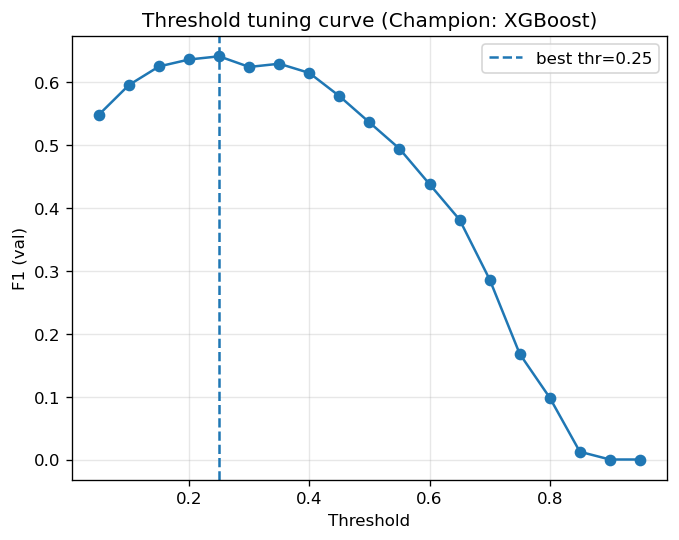

In [19]:
champ_name = thr_df.iloc[0]["model"]
champ_thr  = float(thr_df.iloc[0]["best_thr_val"])
champ_model = results[champ_name][1]

print("Champion:", champ_name)
print("Chosen threshold (val):", champ_thr)

# Plot courbe F1 vs threshold du champion
curve = thr_curves[champ_name]
plt.figure()
plt.plot(curve["thr"], curve["F1"], marker="o")
plt.axvline(champ_thr, linestyle="--", label=f"best thr={champ_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 (val)")
plt.title(f"Threshold tuning curve (Champion: {champ_name})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [38]:
from sklearn.base import clone

# Refit final sur TRAIN+VAL (standard practice)
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

champ_model_final = clone(champ_model)
champ_model_final.fit(X_trainval, y_trainval)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=-1,
              num_parallel_tree=None, ...)

evaluation finale sur test (une seule fois)+confusion matrix 

=== TEST (final) ===
ACC=0.774 | F1=0.684 | AUC=0.854


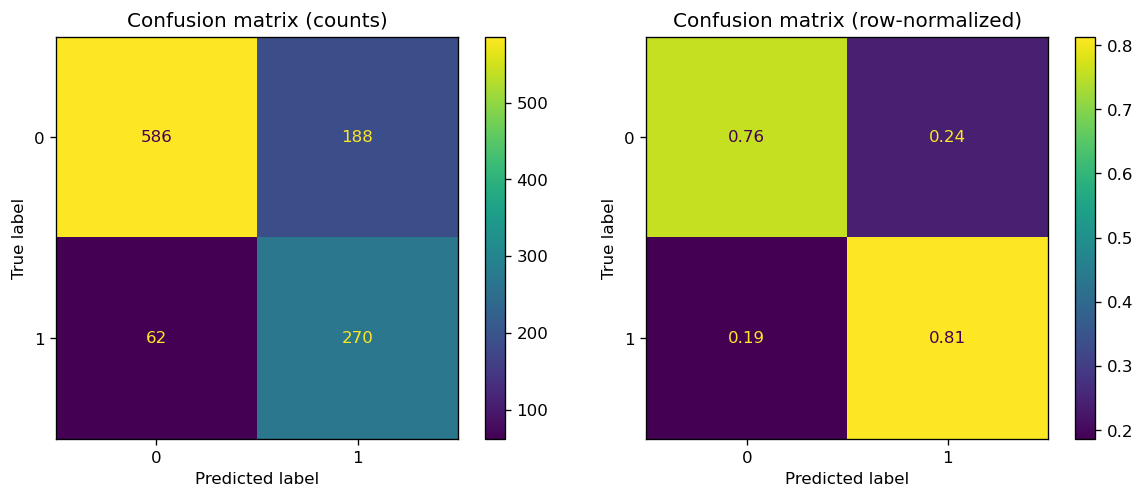

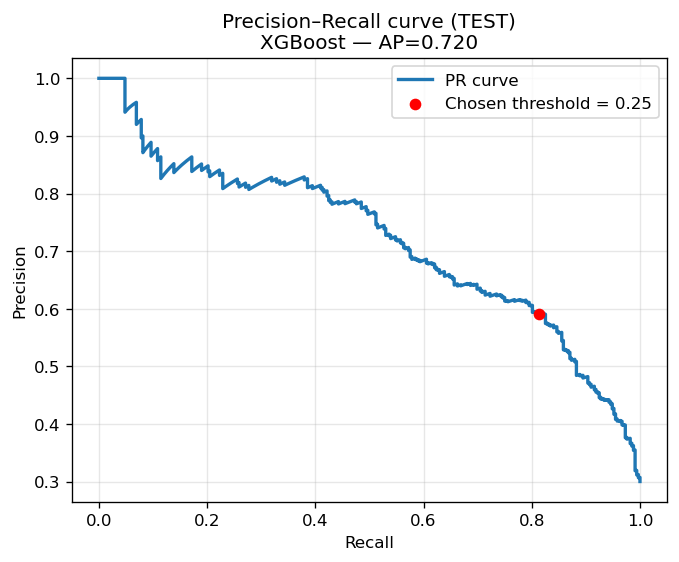

In [40]:
test_out = eval_on_split(champ_model_final, X_test, y_test, thr=champ_thr)
print("=== TEST (final) ===")
print(f"ACC={test_out['ACC']:.3f} | F1={test_out['F1']:.3f} | AUC={test_out['AUC']:.3f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Probabilités sur le jeu de test
proba_test = champ_model_final.predict_proba(X_test)[:, 1]


pred_test = (proba_test >= champ_thr).astype(int)

cm = confusion_matrix(y_test, pred_test)
cm_norm = confusion_matrix(y_test, pred_test, normalize="true")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], values_format="d")
ax[0].set_title("Confusion matrix (counts)")

ConfusionMatrixDisplay(cm_norm).plot(ax=ax[1], values_format=".2f")
ax[1].set_title("Confusion matrix (row-normalized)")

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

proba_test = champ_model_final.predict_proba(X_test)[:, 1]
precision, recall, thresholds_pr = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

# thresholds_pr a une longueur = len(precision)-1
thr_idx = int(np.argmin(np.abs(thresholds_pr - champ_thr)))

# point correspondant au threshold thr_idx => index thr_idx+1 dans precision/recall
pt_recall = recall[thr_idx + 1]
pt_precision = precision[thr_idx + 1]

plt.figure()
plt.plot(recall, precision, lw=2, label="PR curve")
plt.scatter(pt_recall, pt_precision, color="red", zorder=5,
            label=f"Chosen threshold = {champ_thr:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall curve (TEST)\n{champ_name} — AP={ap:.3f}")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()




CV final sur champion 

In [25]:
cv_final = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

accs, f1s, aucs = [], [], []
for tr, te in cv_final.split(X_used, y_used, groups=groups_used):
    m = results[champ_name][1]  # mêmes hyperparams
    # IMPORTANT: on ré-instancie le modèle pour éviter réutilisation état
    # -> on clone proprement:
    from sklearn.base import clone
    m = clone(m)

    m.fit(X_used[tr], y_used[tr])
    proba = m.predict_proba(X_used[te])[:, 1]
    pred  = (proba >= champ_thr).astype(int)

    acc = accuracy_score(y_used[te], pred)
    F = f1_score(y_used[te], pred)
    A = roc_auc_score(y_used[te], proba)

    accs.append(acc); f1s.append(F); aucs.append(A)

print("=== Final grouped CV (champion, fixed thr) ===")
print(f"ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


=== Final grouped CV (champion, fixed thr) ===
ACC: 0.759 ± 0.026
F1 : 0.639 ± 0.042
AUC: 0.844 ± 0.015


ablation study

In [42]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score

# X_raw: (N, T, C) ; raw_cols donne l'ordre des canaux
# On reconstruit un flatten cohérent pour chaque subset de canaux
col_to_channel = {c:i for i,c in enumerate(raw_cols)}

def build_flat_from_channels(X_raw, cols_to_keep):
    ch_idx = [col_to_channel[c] for c in cols_to_keep]
    X_sub = X_raw[:, :, ch_idx]           # (N,T,k)
    return X_sub.reshape(X_sub.shape[0], -1)  # (N, T*k)

def eval_subset(cols_to_keep, thr=0.5):
    X_sub = build_flat_from_channels(X_raw, cols_to_keep)

    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1s = []
    for tr, te in cv.split(X_sub, y_used, groups=groups_used):
        m = clone(champ_model_final)  
        m.fit(X_sub[tr], y_used[tr])
        proba = m.predict_proba(X_sub[te])[:, 1]
        pred = (proba >= thr).astype(int)
        f1s.append(f1_score(y_used[te], pred))
    return np.mean(f1s), np.std(f1s)

rows = []
for subset in [[raw_cols[0]], [raw_cols[1]], raw_cols]:
    mean_f1, std_f1 = eval_subset(subset, thr=0.5)
    rows.append({"subset": "+".join(subset), "F1_mean": mean_f1, "F1_std": std_f1})

display(pd.DataFrame(rows))



,subset,F1_mean,F1_std
0,Speed,0.564099,0.035338
1,turning_angle,0.215075,0.037754
2,Speed+turning_angle,0.562579,0.032570


### Proximity threshold sweep (last N segments)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_segments_from_end(worm_ids, segment_indices):
    seg_from_end = np.zeros_like(segment_indices, dtype=int)
    for wid in np.unique(worm_ids):
        m = (worm_ids == wid)
        idxs = segment_indices[m]
        seg_from_end[m] = idxs.max() - idxs
    return seg_from_end

segments_from_end_all = compute_segments_from_end(worm_ids, segment_indices)

def make_y_near_death(segments_from_end, N_last):
    return (segments_from_end <= N_last).astype(int)

print("Example bincount for N=20:", np.bincount(make_y_near_death(segments_from_end_all, 20)))


Example bincount for N=20: [6016 2134]


In [27]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.base import clone

def cv_eval_for_N(model, X, segments_from_end, worm_ids, N_last, thr=0.5, n_splits=5):
    yN = make_y_near_death(segments_from_end, N_last)
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    accs, f1s, aucs = [], [], []

    for tr, te in cv.split(X, yN, groups=worm_ids):
        m = clone(model)
        m.fit(X[tr], yN[tr])
        proba = m.predict_proba(X[te])[:, 1]
        pred  = (proba >= thr).astype(int)

        accs.append(accuracy_score(yN[te], pred))
        f1s.append(f1_score(yN[te], pred))
        aucs.append(roc_auc_score(yN[te], proba))

    return {
        "pos_rate": float(yN.mean()),
        "ACC_mean": float(np.mean(accs)), "ACC_std": float(np.std(accs)),
        "F1_mean": float(np.mean(f1s)),   "F1_std": float(np.std(f1s)),
        "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
    }

# Choisis une liste de N raisonnable
N_list = [5, 10, 15, 20, 25, 30, 40]

thr_to_use = champ_thr if "champ_thr" in globals() else 0.5

rows = []
for N_last in N_list:
    res = cv_eval_for_N(champ_model, X_flat, segments_from_end_all, worm_ids, N_last, thr=thr_to_use, n_splits=5)
    rows.append({"N_last": N_last, **res})
    print(f"N={N_last:>2} | pos={res['pos_rate']:.3f} | F1={res['F1_mean']:.3f}±{res['F1_std']:.3f} | AUC={res['AUC_mean']:.3f}±{res['AUC_std']:.3f}")

nearN_df = pd.DataFrame(rows)
display(nearN_df)


N= 5 | pos=0.075 | F1=0.220±0.047 | AUC=0.821±0.028
N=10 | pos=0.138 | F1=0.450±0.043 | AUC=0.842±0.019
N=15 | pos=0.200 | F1=0.570±0.033 | AUC=0.844±0.006
N=20 | pos=0.262 | F1=0.639±0.042 | AUC=0.844±0.015
N=25 | pos=0.324 | F1=0.689±0.020 | AUC=0.847±0.010
N=30 | pos=0.388 | F1=0.720±0.035 | AUC=0.840±0.021
N=40 | pos=0.513 | F1=0.764±0.016 | AUC=0.829±0.010


,N_last,pos_rate,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std
0,5,0.075460,0.907724,0.006594,0.219994,0.046592,0.821383,0.028023
1,10,0.138037,0.818950,0.009477,0.449953,0.043341,0.841818,0.018745
2,15,0.199632,0.780748,0.014199,0.569609,0.032891,0.844086,0.005717
3,20,0.261840,0.758522,0.025917,0.639047,0.041768,0.844061,0.014552
4,25,0.324294,0.750048,0.016075,0.688572,0.019920,0.847370,0.009857
5,30,0.387607,0.738990,0.030961,0.720069,0.035187,0.840368,0.020617
6,40,0.513374,0.713147,0.017498,0.763649,0.016395,0.828823,0.010499


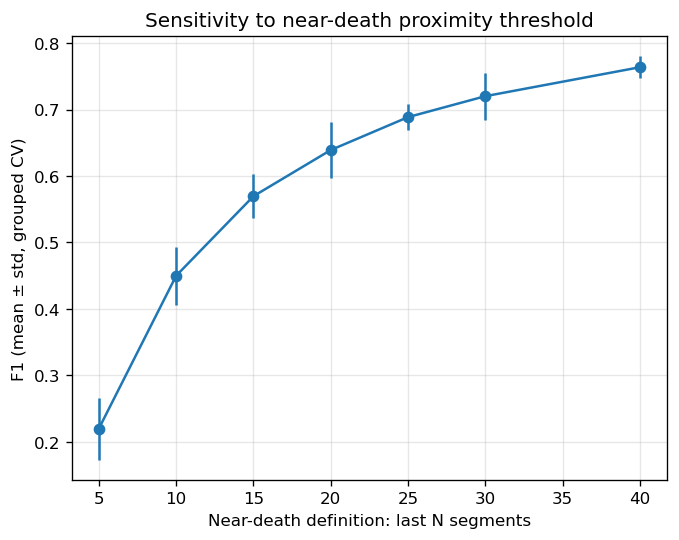

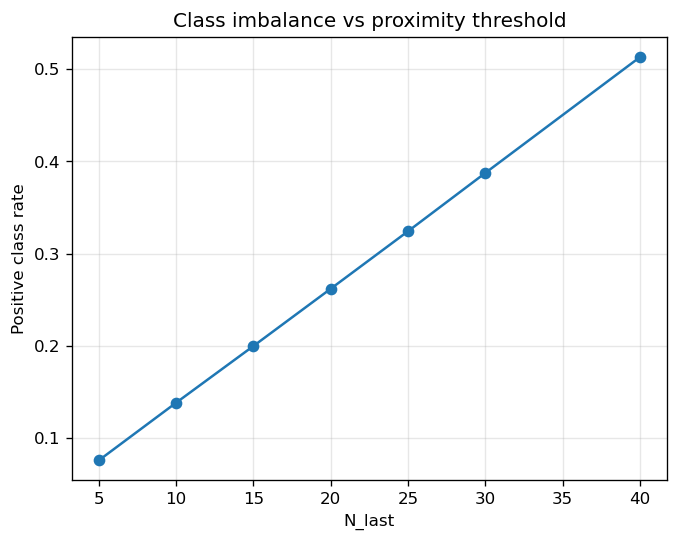

In [28]:
plt.figure()
plt.errorbar(nearN_df["N_last"], nearN_df["F1_mean"], yerr=nearN_df["F1_std"], fmt="o-")
plt.xlabel("Near-death definition: last N segments")
plt.ylabel("F1 (mean ± std, grouped CV)")
plt.title("Sensitivity to near-death proximity threshold")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(nearN_df["N_last"], nearN_df["pos_rate"], marker="o")
plt.xlabel("N_last")
plt.ylabel("Positive class rate")
plt.title("Class imbalance vs proximity threshold")
plt.grid(True, alpha=0.3)
plt.show()


### LIfe-stage analysis (performance par stage de vie) 
On definits des stages bases sur l'age normalisé du segment dans la vie du worm 

In [29]:
def compute_normalized_age(worm_ids, segment_indices):
    # normalized_age = segment_index / max_segment_index per worm
    norm_age = np.zeros_like(segment_indices, dtype=float)
    for wid in np.unique(worm_ids):
        m = (worm_ids == wid)
        idxs = segment_indices[m]
        mx = idxs.max()
        if mx == 0:
            norm_age[m] = 0.0
        else:
            norm_age[m] = idxs / mx
    return norm_age

norm_age_all = compute_normalized_age(worm_ids, segment_indices)

# Définition de stages (4 bins)
def stage_from_norm_age(a):
    # 0..1
    if a < 0.25: return "early"
    if a < 0.50: return "mid"
    if a < 0.75: return "late"
    return "very_late"

stages_all = np.array([stage_from_norm_age(a) for a in norm_age_all])

pd.Series(stages_all).value_counts()


early        2058
very_late    2046
mid          2029
late         2017
Name: count, dtype: int64

dans chaque fold, on entraine sur train, on predit sur test fold puis on calcule les metriques uniquement sur les samples d'un stage. On affrefe fold->fold pour avoir des mean+- std. 

In [30]:
from collections import defaultdict

def stage_metrics_grouped_cv(model, X, y, worm_ids, stages, thr=0.5, n_splits=5):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    per_stage = defaultdict(lambda: {"ACC": [], "F1": [], "AUC": [], "n": []})

    for tr, te in cv.split(X, y, groups=worm_ids):
        m = clone(model)
        m.fit(X[tr], y[tr])
        proba = m.predict_proba(X[te])[:, 1]
        pred  = (proba >= thr).astype(int)

        # metrics par stage sur le test fold
        for st in np.unique(stages):
            mask = (stages[te] == st)
            if mask.sum() < 5:  # trop peu d'exemples -> skip
                continue

            y_true = y[te][mask]
            y_pred = pred[mask]
            y_proba = proba[mask]

            per_stage[st]["n"].append(int(mask.sum()))
            per_stage[st]["ACC"].append(accuracy_score(y_true, y_pred))
            per_stage[st]["F1"].append(f1_score(y_true, y_pred))
            # AUC nécessite 2 classes présentes
            if len(np.unique(y_true)) == 2:
                per_stage[st]["AUC"].append(roc_auc_score(y_true, y_proba))

    # résumé mean±std
    rows = []
    for st, d in per_stage.items():
        rows.append({
            "stage": st,
            "n_mean": np.mean(d["n"]),
            "ACC_mean": np.mean(d["ACC"]), "ACC_std": np.std(d["ACC"]),
            "F1_mean": np.mean(d["F1"]),   "F1_std": np.std(d["F1"]),
            "AUC_mean": np.mean(d["AUC"]) if len(d["AUC"]) else np.nan,
            "AUC_std": np.std(d["AUC"]) if len(d["AUC"]) else np.nan,
        })
    out = pd.DataFrame(rows).sort_values("stage")
    return out

# On garde une définition near-death fixée (ex: N=20) pour faire l'analyse par stage
N_for_stage = 20
y_stage = make_y_near_death(segments_from_end_all, N_for_stage)

thr_to_use = champ_thr if "champ_thr" in globals() else 0.5

stage_df = stage_metrics_grouped_cv(champ_model, X_flat, y_stage, worm_ids, stages_all, thr=thr_to_use, n_splits=5)
display(stage_df)


,stage,n_mean,ACC_mean,ACC_std,F1_mean,F1_std,AUC_mean,AUC_std
0,early,411.6,0.912888,0.021682,0.000000,0.000000,NaN,NaN
1,late,403.4,0.472254,0.090683,0.201159,0.094572,0.488603,0.067855
2,mid,405.8,0.841607,0.020424,0.000000,0.000000,0.535965,0.069298
3,very_late,409.2,0.802400,0.040324,0.888177,0.025343,0.622738,0.050713


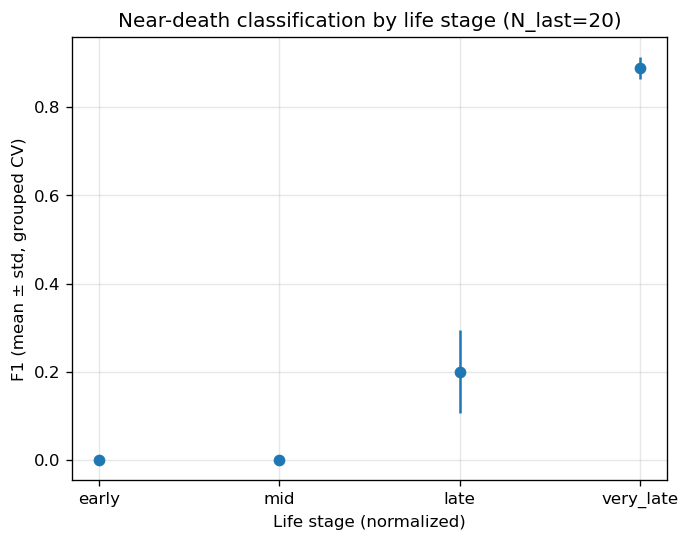

In [31]:
# Ordre explicite
order = ["early", "mid", "late", "very_late"]
stage_df["stage"] = pd.Categorical(stage_df["stage"], categories=order, ordered=True)
stage_df = stage_df.sort_values("stage")

plt.figure()
plt.errorbar(stage_df["stage"], stage_df["F1_mean"], yerr=stage_df["F1_std"], fmt="o")
plt.xlabel("Life stage (normalized)")
plt.ylabel("F1 (mean ± std, grouped CV)")
plt.title(f"Near-death classification by life stage (N_last={N_for_stage})")
plt.grid(True, alpha=0.3)
plt.show()
